**This is a 3 Notebook Series on:**
# Fundamental of Accelerated Computing with CUDA Python
In this 3 Notebook Series you will learn about:
1. [Introduction to CUDA Python with Numba](https://www.kaggle.com/harshwalia/1-introduction-to-cuda-python-with-numba)
2. [Custom CUDA Kernels in Python with Numba](https://www.kaggle.com/harshwalia/2-custom-cuda-kernels-in-python-with-numba)
3. [Multidimensional Grids and Shared Memory for CUDA Python with Numba](https://www.kaggle.com/harshwalia/3-multidimensional-grids-shared-memory-for-cuda)

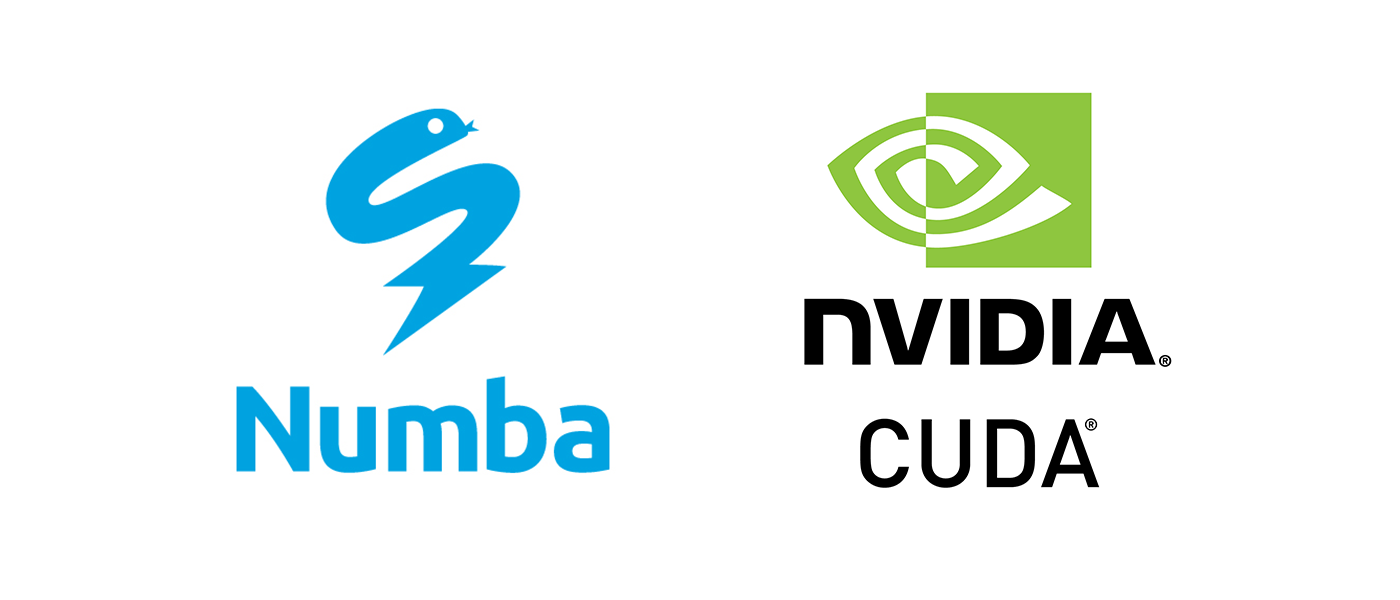

If you Gain some knowledge then **Please Upvote**

Thanks to NVIDIA Deeplearning Institute for such a Good Content.

# 2- Custom CUDA Kernels in Python with Numba

In this section we will go further into our understanding of how the CUDA programming model organizes parallel work, and will leverage this understanding to write custom CUDA **kernels**, functions which run in parallel on CUDA GPUs. Custom CUDA kernels, in utilizing the CUDA programming model, require more work to implement than, for example, simply decorating a ufunc with `@vectorize`. However, they make possible parallel computing in places where ufuncs are just not able, and provide a flexibility that can lead to the highest level of performance.

This section contains three appendices for those of you interested in futher study: a variety of debugging techniques to assist your GPU programming, links to CUDA programming references, and coverage of Numba supported random number generation on the GPU.

## Objectives

By the time you complete this section you will be able to:

* Write custom CUDA kernels in Python and launch them with an execution configuration.
* Utilize grid stride loops for working in parallel over large data sets and leveraging memory coalescing.
* Use atomic operations to avoid race conditions when working in parallel.

## The Need for Custom Kernels

Ufuncs are fantastically elegant, and for any scalar operation that ought to be performed element wise on data, ufuncs are likely the right tool for the job.

As you are well aware, there are many, if not more, classes of problems that cannot be solved by applying the same function to each element of a data set. Consider, for example, any problem that requires access to more than one element of a data structure in order to calculate its output, like stencil algorithms, or any problem that cannot be expressed by a one input value to one output value mapping, such as a reduction. Many of these problems are still inherently parallelizable, but cannot be expressed by a ufunc.

Writing custom CUDA kernels, while more challenging than writing GPU accelerated ufuncs, provides developers with tremendous flexibility for the types of functions they can send to run in parallel on the GPU. Furthermore, as you will begin learning in this and the next section, it also provides fine-grained control over *how* the parallelism is conducted by exposing CUDA's thread hierarchy to developers explicitly.

While remaining purely in Python, the way we write CUDA kernels using Numba is very reminiscent of how developers write them in CUDA C/C++. For those of you familiar with programming in CUDA C/C++, you will likely pick up custom kernels in Python with Numba very rapidly, and for those of you learning them for the first time, know that the work you do here will also serve you well should you ever need or wish to develop CUDA in C/C++, or even, make a study of the wealth of CUDA resources on the web that are most commonly portraying CUDA C/C++ code.

## Introduction to CUDA Kernels

When programming in CUDA, developers write functions for the GPU called **kernels**, which are executed, or in CUDA parlance, **launched**, on the GPU's many cores in parallel **threads**. When kernels are launched, programmers use a special syntax, called an **execution configuration** (also called a launch configuration) to describe the parallel execution's configuration.

The following slides (which will appear after executing the cell below) give a high level introduction to how CUDA kernels can be created to work on large datasets in parallel on the GPU device. Work through the slides and then you will begin writing and executing your own custom CUDA kernels, using the ideas presented in the slides.

In [1]:
from IPython.display import IFrame
IFrame('https://view.officeapps.live.com/op/view.aspx?src=https://developer.download.nvidia.com/training/courses/C-AC-02-V1/AC_CUDA_Python_1.pptx', 640, 390)

## A First CUDA Kernel

Let's start with a concrete, and very simple example by rewriting our addition function for 1D NumPy arrays. CUDA kernels are compiled using the `numba.cuda.jit` decorator. `numba.cuda.jit` is not to be confused with the `numba.jit` decorator you've already learned which optimizes functions **for the CPU**.

We will begin with a very simple example to highlight some of the essential syntax. Worth mentioning is that this particular function could in fact be written as a ufunc, but we choose it here to keep the focus on learning the syntax. We will be proceeding to functions more well suited to being written as a custom kernel below. Be sure to read the comments carefully, as they provide some important information about the code.

In [1]:
from numba import cuda

# Note the use of an `out` array. CUDA kernels written with `@cuda.jit` do not return values,
# just like their C counterparts. Also, no explicit type signature is required with @cuda.jit
@cuda.jit
def add_kernel(x, y, out):
    
    # The actual values of the following CUDA-provided variables for thread and block indices,
    # like function parameters, are not known until the kernel is launched.
    
    # This calculation gives a unique thread index within the entire grid (see the slides above for more)
    idx = cuda.grid(1)          # 1 = one dimensional thread grid, returns a single value.
                                # This Numba-provided convenience function is equivalent to
                                # `cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x`

    # This thread will do the work on the data element with the same index as its own
    # unique index within the grid.
    out[idx] = x[idx] + y[idx]

In [2]:
import numpy as np

n = 4096
x = np.arange(n).astype(np.int32) # [0...4095] on the host
y = np.ones_like(x)               # [1...1] on the host

d_x = cuda.to_device(x) # Copy of x on the device
d_y = cuda.to_device(y) # Copy of y on the device
d_out = cuda.device_array_like(d_x) # Like np.array_like, but for device arrays

# Because of how we wrote the kernel above, we need to have a 1 thread to one data element mapping,
# therefore we define the number of threads in the grid (128*32) to equal n (4096).
threads_per_block = 128
blocks_per_grid = 32

In [4]:
add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)
cuda.synchronize()
print(d_out.copy_to_host()) # Should be [1...4096]

[   1    2    3 ... 4094 4095 4096]


### Exercise: Tweak the Code

Make the following minor changes to the code above to see how it affects its execution. Make educated guesses about what will happen before running the code:

* Decrease the `threads_per_block` variable
* Decrease the `blocks_per_grid` variable
* Increase the `threads_per_block` and/or `blocks_per_grid variables`
* Remove or comment out the `cuda.synchronize()` call

### Results

In the example above, because the kernel is written so that each thread works on exactly one data element, it is essential for the number of threads in the grid equal the number of data elements.

By **reducing the number of threads in the grid**, either by reducing the number of blocks, and/or reducing the number of threads per block, there are elements where work is left undone and thus we can see in the output that the elements toward the end of the `d_out` array did not have any values added to it. If you edited the execution configuration by reducing the number of threads per block, then in fact there are other elements through the `d_out` array that were not processed.

**Increasing the size of the grid** in fact creates issues with out of bounds memory access. This error will not show in your code presently, but later in this section you will learn how to expose this error using `cuda-memcheck` and debug it.

You might have expected that **removing the synchronization point** would have resulted in a print showing that no or less work had been done. This is a reasonable guess since without a synchronization point the CPU will work asynchronously while the GPU is processing. The detail to learn here is that memory copies carry implicit synchronization, making the call to `cuda.synchronize` above unnecessary.

### Exercise: Accelerate a CPU Function as a Custom CUDA Kernel

Below is CPU scalar function `square_device` that could be used as a CPU ufunc. Your job is to refactor it to run as a CUDA kernel decorated with the `@cuda.jit` decorator.

You might think that making this function run on the device could be much more easily done with `@vectorize`, and you would be correct. But this scenario will give you a chance to work with all the syntax we've introduced before moving on to more complicated and realistic examples.

In this exercise you will need to:
* Refactor the `square_device` definition to be a CUDA kernel that will do one thread's worth of work on a single element.
* Refactor the `d_a` and `d_out` arrays below to be CUDA device arrays.
* Modify the `blocks` and `threads` variables to appropriate values for the provided `n`.
* Refactor the call to `square_device` to be a kernel launch that includes an execution configuration.

The assertion test below will fail until you successfully implement the above. If you get stuck, feel free to check out a [solution](../edit/solutions/square_device_solution.py).

In [5]:
# Refactor to be a CUDA kernel doing one thread's work.
# Don't forget that when using `@cuda.jit`, you must provide an output array as no value will be returned.
@cuda.jit
def square_device(a,out):
    idx = cuda.grid(1)
    out[idx] = a[idx]**2

In [6]:
# Leave the values in this cell fixed for this exercise
n = 4096

a = np.arange(n)
out = a**2           # `out` will only be used for testing below

In [7]:
d_a = cuda.to_device(a)                                   # TODO make `d_a` a device array
d_out = cuda.device_array(shape=(n,), dtype=np.float32)    # TODO: make d_out a device array


# TODO: Update the execution configuration for the amount of work needed
blocks = 128
threads = 32

# TODO: Launch as a kernel with an appropriate execution configuration
d_out = square_device[blocks,threads](d_a,d_out)

## An Aside on Hiding Latency and Execution Configuration Choices

CUDA enabled NVIDIA GPUs consist of several [**Streaming Multiprocessors**](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#hardware-implementation), or **SMs** on a die, with attached DRAM. SMs contain all required resources for the execution of kernel code including many CUDA cores. When a kernel is launched, each block is assigned to a single SM, with potentially many blocks assigned to a single SM. SMs partition blocks into further subdivisions of 32 threads called **warps** and it is these warps which are given parallel instructions to execute.

When an instruction takes more than one clock cycle to complete (or in CUDA parlance, to **expire**) the SM can continue to do meaningful work *if it has additional warps that are ready to be issued new instructions.* Because of very large register files on the SMs, there is no time penalty for an SM to change context between issuing instructions to one warp or another. In short, the latency of operations can be hidden by SMs with other meaningful work so long as there is other work to be done.

**Therefore, of primary importance to utilizing the full potential of the GPU, and thereby writing performant accelerated applications, it is essential to give SMs the ability to hide latency by providing them with a sufficient number of warps which can be accomplished most simply by executing kernels with sufficiently large grid and block dimensions.**

Deciding the very best size for the CUDA thread grid is a complex problem, and depends on both the algorithm and the specific GPU's [compute capability](https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#compute-capabilities), but here are some very rough heuristics that we tend to follow and which can work well for getting started:

  * The size of a block should be a multiple of 32 threads (the size of a warp), with typical block sizes between 128 and 512 threads per block.
  * The size of the grid should ensure the full GPU is utilized where possible. Launching a grid where the number of blocks is 2x-4x the number of SMs on the GPU is a good starting place. Something in the range of 20 - 100 blocks is usually a good starting point.
  * The CUDA kernel launch overhead does increase with the number of blocks, so when the input size is very large we find it best not to launch a grid where the number of threads equals the number of input elements, which would result in a tremendous number of blocks. Instead we use a pattern to which we will now turn our attention for dealing with large inputs.

## Working on Largest Datasets with Grid Stride Loops

The following slides give a high level overview of a technique called a **grid stride loop** which will create flexible kernels where each thread is able to work on more than one data element, an essential technique for large datasets. Execute the cell to load the slides.

Read slides before working on Grid Stride Loops

In [8]:
from IPython.display import IFrame
IFrame('https://view.officeapps.live.com/op/view.aspx?src=https://developer.download.nvidia.com/training/courses/C-AC-02-V1/AC_CUDA_Python_2.pptx', 640, 390)

## A First Grid Stride Loop

Let's refactor the `add_kernel` above to utilize a grid stride loop so that we can launch it to work on larger data sets flexibly while incurring the benefits of global **memory coalescing**, which allows parallel threads to access memory in contiguous chunks, a scenario which the GPU can leverage to reduce the total number of memory operations:

In [9]:
from numba import cuda

@cuda.jit
def add_kernel(x, y, out):
    

    start = cuda.grid(1)
    
    # This calculation gives the total number of threads in the entire grid
    stride = cuda.gridsize(1)   # 1 = one dimensional thread grid, returns a single value.
                                # This Numba-provided convenience function is equivalent to
                                # `cuda.blockDim.x * cuda.gridDim.x`

    # This thread will start work at the data element index equal to that of its own
    # unique index in the grid, and then, will stride the number of threads in the grid each
    # iteration so long as it has not stepped out of the data's bounds. In this way, each
    # thread may work on more than one data element, and together, all threads will work on
    # every data element.
    for i in range(start, x.shape[0], stride):
        # Assuming x and y inputs are same length
        out[i] = x[i] + y[i]

In [10]:
import numpy as np

n = 100000 # This is far more elements than threads in our grid
x = np.arange(n).astype(np.int32)
y = np.ones_like(x)

d_x = cuda.to_device(x)
d_y = cuda.to_device(y)
d_out = cuda.device_array_like(d_x)

threads_per_block = 128
blocks_per_grid = 30

In [11]:
add_kernel[blocks_per_grid, threads_per_block](d_x, d_y, d_out)
print(d_out.copy_to_host()) # Remember, memory copy carries implicit synchronization

[     1      2      3 ...  99998  99999 100000]


### Exercise: Implement a Grid Stride Loop

Refactor the following CPU scalar `hypot_stride` function to run as a CUDA Kernel utilizing a grid stride loop. 

In [12]:
from math import hypot

@cuda.jit
def hypot_stride(a, b, c):
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)
    
    for i in range(idx, a.shape[0], stride):
        c[i] = hypot(a[i], b[i])

In [13]:
# You do not need to modify the contents in this cell
n = 1000000
a = np.random.uniform(-12, 12, n).astype(np.float32)
b = np.random.uniform(-12, 12, n).astype(np.float32)
d_a = cuda.to_device(a)
d_b = cuda.to_device(b)
d_c = cuda.device_array_like(d_b)

blocks = 128
threads_per_block = 64

hypot_stride[blocks, threads_per_block](d_a, d_b, d_c)

In [14]:
from numpy import testing
# This assertion will fail until you successfully implement the hypot_stride kernel above
testing.assert_almost_equal(np.hypot(a,b), d_c.copy_to_host(), decimal=5)

## Timing the Kernel

Let's take the time to do some performance timing for the `hypot_stride` kernel. 

### CPU Baseline

First let's get a baseline with `np.hypot`:

In [15]:
%timeit np.hypot(a, b)

6.1 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Numba on the CPU

Next let's see about a CPU optimized version:

In [16]:
from numba import jit

@jit
def numba_hypot(a, b):
    return np.hypot(a, b)

In [17]:
%timeit numba_hypot(a, b)

6.03 ms ± 98.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Single Threaded on the Device

Just to see, let's launch our kernel in a grid with only a single thread. Here we will use `%time`, which only runs the statement once to ensure our measurement isn't affected by the finite depth of the CUDA kernel queue. We will also add a `cuda.synchronize` to be sure we don't get any innacurate times on account of returning control to the CPU, where the timer is, before the kernel completes:

In [18]:
%time hypot_stride[1, 1](d_a, d_b, d_c); cuda.synchronize()

CPU times: user 291 ms, sys: 0 ns, total: 291 ms
Wall time: 292 ms


Hopefully not too much of a surprise that this is way slower than even the baseline CPU execution.

### Parallel on the Device

In [19]:
%time hypot_stride[128, 64](d_a, d_b, d_c); cuda.synchronize()

CPU times: user 1.49 ms, sys: 28 µs, total: 1.52 ms
Wall time: 1.2 ms


That's much faster!

## Atomic Operations and Avoiding Race Conditions

CUDA, like many general purpose parallel execution frameworks, makes it possible to have race conditions in your code.  A race condition in CUDA arises when threads read to or write from a memory location that might be modified by another independent thread. Generally speaking, you need to worry about:

 * read-after-write hazards: One thread is reading a memory location at the same time another thread might be writing to it.
 * write-after-write hazards: Two threads are writing to the same memory location, and only one write will be visible when the kernel is complete.
 
A common strategy to avoid both of these hazards is to organize your CUDA kernel algorithm such that each thread has exclusive responsibility for unique subsets of output array elements, and/or to never use the same array for both input and output in a single kernel call. (Iterative algorithms can use a double-buffering strategy if needed, and switch input and output arrays on each iteration.)

However, there are many cases where different threads need to combine results. Consider something very simple, like: "every thread increments a global counter." Implementing this in your kernel requires each thread to:

1. Read the current value of a global counter.
2. Compute `counter + 1`.
3. Write that value back to global memory.

However, there is no guarantee that another thread has not changed the global counter between steps 1 and 3. To resolve this problem, CUDA provides **atomic operations** which will read, modify and update a memory location in one, indivisible step. Numba supports several of these functions, [described here](http://numba.pydata.org/numba-doc/dev/cuda/intrinsics.html#supported-atomic-operations).

Let's make our thread counter kernel:

In [20]:
@cuda.jit
def thread_counter_race_condition(global_counter):
    global_counter[0] += 1  # This is bad
    
@cuda.jit
def thread_counter_safe(global_counter):
    cuda.atomic.add(global_counter, 0, 1)  # Safely add 1 to offset 0 in global_counter array

In [21]:
# This gets the wrong answer
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_race_condition[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [1]


In [22]:
# This works correctly
global_counter = cuda.to_device(np.array([0], dtype=np.int32))
thread_counter_safe[64, 64](global_counter)

print('Should be %d:' % (64*64), global_counter.copy_to_host())

Should be 4096: [4096]


## Assessment

The following exercise will require you to utilize everything you've learned so far. 

**Please read the directions carefully before beginning your work to complete  the assessment.**

`Well i have solved the assignment for you`

### How to Run the Assessment

Take the following steps to complete this assessment:

1. Using the instructions that follow, work on the cells below as you usually would for an exercise.


### Write an Accelerated Histogramming Kernel

For this assessment, you will create an accelerated histogramming kernel. This will take an array of input data, a range, and a number of bins, and count how many of the input data elements land in each bin. Below is a working CPU implementation of histogramming to serve as an example for your work:

In [23]:
def cpu_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    # Note that we don't have to pass in nbins explicitly, because the size of histogram_out determines it
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    # This is a very slow way to do this with NumPy, but looks similar to what you will do on the GPU
    for element in x:
        bin_number = np.int32((element - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            # only increment if in range
            histogram_out[bin_number] += 1

In [24]:
x = np.random.normal(size=10000, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

cpu_histogram(x, xmin, xmax, histogram_out)

histogram_out

array([   5,   76,  491, 1562, 2868, 2882, 1553,  498,   59,    5],
      dtype=int32)

Using a grid stride loop and atomic operations, implement your solution in the cell below. 

In [25]:
@cuda.jit
def cuda_histogram(x, xmin, xmax, histogram_out):
    '''Increment bin counts in histogram_out, given histogram range [xmin, xmax).'''
    
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins
    
    start = cuda.grid(1)
    stride=cuda.gridsize(1)
    
    for i in range(start, x.shape[0], stride):
        bin_number = np.int32((x[i] - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            # only increment if in range
            cuda.atomic.add(histogram_out, bin_number, 1)
    

In [26]:
d_x = cuda.to_device(x)
d_histogram_out = cuda.to_device(np.zeros(shape=10, dtype=np.int32))

blocks = 128
threads_per_block = 64

cuda_histogram[blocks, threads_per_block](d_x, xmin, xmax, d_histogram_out)

In [27]:
# This assertion will fail until you correctly implement `cuda_histogram`
np.testing.assert_array_almost_equal(d_histogram_out.copy_to_host(), histogram_out, decimal=2)

## Summary

In this section you learned how to:

* Write custom CUDA kernels in Python and launch them with an execution configuration.
* Utilize grid stride loops for working in parallel over large data sets and leveraging memory coalescing.
* Use atomic operations to avoid race conditions when working in parallel.

**Please Upvote** If you gain Some knowledge